In [1]:
import warnings
warnings.filterwarnings("ignore")
from bertopic import BERTopic
from wordcloud import WordCloud
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
import json
import pandas as pd
from helpers import convert_filename

In [2]:
RESULTS_DIR = "findings"

In [3]:
stop_words = None
with open("stopwords.txt", "r") as stop_file:
    stop_words = set(stop_file.read().splitlines())

Start Lemmatized Tweets Processing

In [4]:
tweets = []
classes = []
candidates = []
lemm_tweets = None
timestamps = []
cand_subset = ["Recep Tayyip Erdoğan", "Kemal Kılıçdaroğlu"]

with open("data/lemm_tweets.json", "r") as in_file:
    lemm_tweets = json.load(in_file)

for candidate, candidate_tweets in lemm_tweets.items():
    if candidate not in cand_subset:
        continue

    candidates.append(candidate)
    for tweet in candidate_tweets:
        non_stop_words = []

        for word in tweet["tweet"].split():
            if word not in stop_words:
                non_stop_words.append(word)

        if len(non_stop_words) > 0:
            tweets.append(" ".join(non_stop_words))
            classes.append(candidate)
            timestamps.append(tweet["date"])

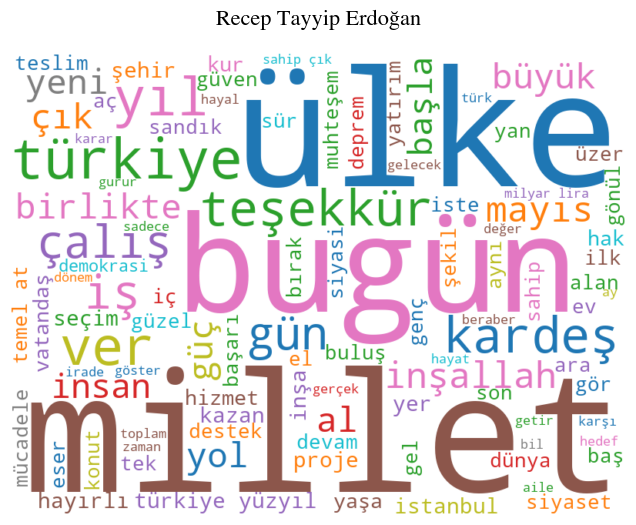

Total: 15278
Recep Tayyip Erdoğan
millet 1.27, 194
ülke 1.12, 171
türkiye 0.93, 142
yıl 0.84, 129
ver 0.82, 126
kardeş 0.71, 109
bugün 0.67, 102
mayıs 0.63, 97
çık 0.62, 94
çalış 0.53, 81
konut 0.52, 79
teşekkür 0.52, 79
al 0.51, 78
inşallah 0.51, 78
iş 0.50, 77
--------------------------------------------------


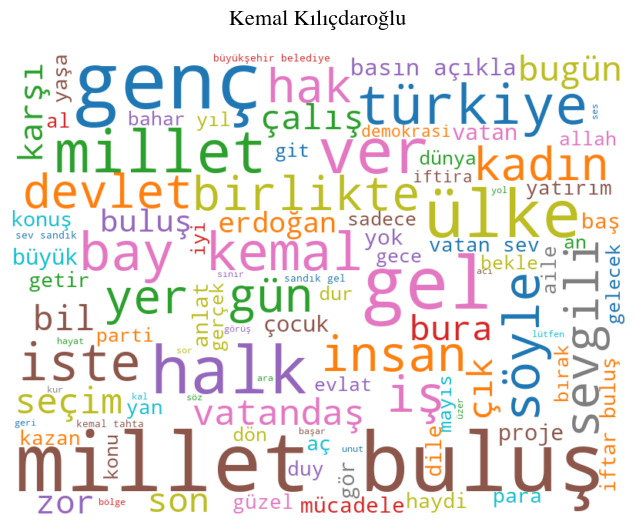

Total: 3809
Kemal Kılıçdaroğlu
millet 1.92, 73
buluş 1.89, 72
gel 1.21, 46
genç 1.18, 45
ver 0.89, 34
halk 0.79, 30
ülke 0.79, 30
kemal 0.63, 24
vatan 0.55, 21
türkiye 0.55, 21
sandık 0.55, 21
bura 0.53, 20
bay 0.53, 20
iste 0.50, 19
söyle 0.47, 18
--------------------------------------------------


In [9]:
title_font = {"family": "Times", "size": 16}

for cand, cand_tweets in lemm_tweets.items():
    if cand not in cand_subset:
        continue

    wc = WordCloud(max_words=100, random_state=42, width=800, height=600,
                   stopwords=stop_words, background_color="white", colormap="tab10", min_font_size=6)
    words = " ".join([tweet["tweet"] for tweet in cand_tweets])
    wc.generate(words)

    plt.figure(figsize=(8, 6))
    plt.title(cand, fontdict=title_font, pad=20)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")

    file_name = convert_filename(cand).lower()

    wc_svg = wc.to_svg(embed_font=True)
    # with open(f"{RESULTS_DIR}/wc_{file_name}.svg", "w") as out_file:
    #     out_file.write(wc_svg)
    plt.show()

    word_list = words.split()
    total_num_of_words = len(word_list)
    print(f"Total: {total_num_of_words}")
    counter = Counter(word_list)
    most_common = counter.most_common(15)
    print(cand)
    for el in most_common:
        print(f"{el[0]} {'{:.2f}'.format(el[1] * 100 / total_num_of_words)}, {el[1]}")
    print("-" * 50) 
    


In [7]:
topic_model = BERTopic(language="multilingual", verbose=True)
topics, probs = topic_model.fit_transform(tweets)

Batches:   0%|          | 0/31 [00:00<?, ?it/s]

2023-06-15 10:28:04,643 - BERTopic - Transformed documents to Embeddings
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2023-06-15 10:28:08,494 - BERTopic - Reduced dimensionality
2023-06-15 10:28:08,517 - BERTopic - Clustered reduced embeddings


In [17]:
topics_to_merge = [2, 7, 8, 11]
topic_model.merge_topics(tweets, topics_to_merge)

topics_to_merge = [8, 11]
topic_model.merge_topics(tweets, topics_to_merge)

In [22]:
# topic_model.reduce_topics(tweets, nr_topics=24)

topic_labels_lemm = topic_model.generate_topic_labels(
    nr_words=5, topic_prefix=False, separator=", ")

topic_model.set_topic_labels(topic_labels_lemm)
df = topic_model.get_topic_info()
df.to_excel(f"{RESULTS_DIR}/topics.xlsx", index=False)
df.head(25)

,Topic,Count,Name,CustomName
0,-1,258,-1_ülke_genç_iş_kardeş,"ülke, genç, iş, kardeş, millet"
1,0,162,0_buluş_millet_muhteşem_erzurum,"buluş, millet, muhteşem, erzurum, hatay"
2,1,106,1_konut_deprem_temel_at,"konut, deprem, temel, at, ev"
3,2,79,2_rahmet_atatürk_şehit_dile,"rahmet, atatürk, şehit, dile, allah"
4,3,71,3_türkiye_yüzyıl_ülke_mayıs,"türkiye, yüzyıl, ülke, mayıs, millet"
5,4,62,4_seçim_sandık_millet_mayıs,"seçim, sandık, millet, mayıs, oy"
6,5,45,5_teşekkür_kardeş_muhteşem_güzel,"teşekkür, kardeş, muhteşem, güzel, istanbul"
7,6,43,6_canlı_yayın_tv_basın,"canlı, yayın, tv, basın, açıkla"
8,7,36,7_gel_sev_haydi_vatan,"gel, sev, haydi, vatan, bura"
9,8,30,8_milyar_yatırım_lira_kamu,"milyar, yatırım, lira, kamu, dolar"


In [23]:
rep_docs_dict = {}
for i in range(14):
    rep_docs = topic_model.get_representative_docs(i)
    rep_docs_dict[i] = rep_docs

In [24]:
df_topics = pd.DataFrame.from_dict(rep_docs_dict).T
df_topics.to_excel("findings/representative_docs.xlsx")
df_topics.head()

,0,1,2
0,millet buluş hatay,millet buluş,millet buluş istanbul
1,deprem felaket ikinci hafta kal konut inşa adı...,bugün hatay temel at konut birlikte toplam kon...,şanlıurfa deprem konut temel at konut dükkan v...
2,istiklal aşık millet yaz büyük destan çanakkal...,mayıs git yol büyük kucaklaş atatürk havaliman...,bugün milli mücadele başkomutan cumhuriyet ban...
3,masa yumrukla hamaset dün söyle bugün inkar mi...,mayıs seçim türkiye yıl eser hizmet üre yıl la...,mayıs demokrasi sancı yol ayrım mayıs istanbul...
4,yurt dış yaşa sevgili vatandaş rekor katılım s...,mayıs başla yurt dış oy kullan işlem bugün iti...,tarih yüksek katılım seçim mayıs seçim aziz mi...


In [25]:
fig = topic_model.visualize_barchart(top_n_topics=18, n_words=8, width=300)
fig.write_image(f"{RESULTS_DIR}/topic_word_scores.pdf")
fig.show()

In [26]:
topics_per_class = topic_model.topics_per_class(tweets, classes=classes)
fig = topic_model.visualize_topics_per_class(
    topics_per_class, top_n_topics=18, width=1000, custom_labels=True)
fig.write_html(f"{RESULTS_DIR}/topics_per_class.html")
fig.show()

2it [00:00, 74.32it/s]


In [30]:
topics_per_class

,Topic,Words,Frequency,Class,Name
0,-1,"ülke, kardeş, iş, millet, genç",145,Recep Tayyip Erdoğan,"ülke, genç, iş, kardeş, millet"
1,0,"muhteşem, buluş, millet, hatay, erzurum",90,Recep Tayyip Erdoğan,"buluş, millet, muhteşem, erzurum, hatay"
2,1,"konut, deprem, temel, at, ev",98,Recep Tayyip Erdoğan,"konut, deprem, temel, at, ev"
3,2,"rahmet, atatürk, şehit, gazi, teşekkür",54,Recep Tayyip Erdoğan,"rahmet, atatürk, şehit, dile, allah"
4,3,"türkiye, yüzyıl, ülke, mayıs, millet",52,Recep Tayyip Erdoğan,"türkiye, yüzyıl, ülke, mayıs, millet"
5,4,"seçim, sandık, mayıs, millet, oy",35,Recep Tayyip Erdoğan,"seçim, sandık, millet, mayıs, oy"
6,5,"teşekkür, kardeş, muhteşem, güzel, istanbul",41,Recep Tayyip Erdoğan,"teşekkür, kardeş, muhteşem, güzel, istanbul"
7,6,"canlı, yayın, ortak, tv, bölüm",16,Recep Tayyip Erdoğan,"canlı, yayın, tv, basın, açıkla"
8,7,"togg, uğurla, yol, mersin, yalnız",11,Recep Tayyip Erdoğan,"gel, sev, haydi, vatan, bura"
9,8,"milyar, yatırım, lira, kamu, yıl",28,Recep Tayyip Erdoğan,"milyar, yatırım, lira, kamu, dolar"


In [32]:
for candidate in candidates:
    df = topics_per_class.query('Class == "' + candidate + '" and Topic > -1').sort_values(
        by=["Frequency"], ascending=False).drop("Class", axis=1).head(12)

    file_name = convert_filename(candidate).lower()
    df.to_excel(f"{RESULTS_DIR}/{file_name}.xlsx", index=False)

    print(candidate)
    print(df.to_string(index=False))
    print("\n\n")

Recep Tayyip Erdoğan
 Topic                                       Words  Frequency                                        Name
     1                konut, deprem, temel, at, ev         98                konut, deprem, temel, at, ev
     0     muhteşem, buluş, millet, hatay, erzurum         90     buluş, millet, muhteşem, erzurum, hatay
     2      rahmet, atatürk, şehit, gazi, teşekkür         54         rahmet, atatürk, şehit, dile, allah
     3        türkiye, yüzyıl, ülke, mayıs, millet         52        türkiye, yüzyıl, ülke, mayıs, millet
     5 teşekkür, kardeş, muhteşem, güzel, istanbul         41 teşekkür, kardeş, muhteşem, güzel, istanbul
     4            seçim, sandık, mayıs, millet, oy         35            seçim, sandık, millet, mayıs, oy
     8            milyar, yatırım, lira, kamu, yıl         28          milyar, yatırım, lira, kamu, dolar
     9      nükleer, santral, enerji, üretim, ülke         23      nükleer, santral, enerji, üretim, ülke
     6              canlı

In [29]:
fig = topic_model.visualize_documents(
    tweets, custom_labels=True, topics=list(range(12)))
fig.write_html(f"{RESULTS_DIR}/doc_visualization.html")
fig.show()

In [33]:
dates = [datetime.fromtimestamp(ts).strftime(
    "%Y-%m-%d %H:%M:%S") for ts in timestamps]
topics_over_time = topic_model.topics_over_time(
    tweets, dates, nr_bins=50, datetime_format="%Y-%m-%d %H:%M:%S")
fig = topic_model.visualize_topics_over_time(
    topics_over_time, top_n_topics=18, height=600)
fig.write_html(f"{RESULTS_DIR}/topics_over_time.html")
fig.show()

50it [00:00, 149.09it/s]
